# Analysing the calibration of the Perch_v2 model on BirdSet

In [18]:
# Load predictions from each test set by looping over all folders in /workspace/logs/predictions/convnext_bs and load the .pkl files

# load data in dict form: data[<dataset_name>] = (predictions, targets, metadata)
import os
import torch
from matplotlib import pyplot as plt
from uncertainbird.utils.misc import load_dump

data = {}

log_dir = "/workspace/logs/predictions/perch_v2"
dataset_names = sorted(
    [d for d in os.listdir(log_dir) if os.path.isdir(os.path.join(log_dir, d))]
)

# colormap without red (tab10 index 3 is red)
colors = plt.cm.tab10
skip_index = 3
available_indices = [i for i in range(colors.N) if i != skip_index]
dataset_colors = {}

for i, ds in enumerate(dataset_names):
    data[ds] = {}
    color_idx = available_indices[i % len(available_indices)]
    dataset_colors[ds] = colors(color_idx)

    ds_path = os.path.join(log_dir, ds)
    pkl_files = [f for f in os.listdir(ds_path) if f.endswith(".pkl")]
    if not pkl_files:
        continue
    # pick most recent file
    pkl_files.sort(
        key=lambda f: os.path.getmtime(os.path.join(ds_path, f)), reverse=True
    )
    file_path = os.path.join(ds_path, pkl_files[0])
    preds, t, metadata = load_dump(file_path)
    data[ds]["predictions"] = preds
    data[ds]["targets"] = t.int()
    data[ds]["metadata"] = metadata
    data[ds]["color"] = dataset_colors[ds]

# concatenate
valid_keys = [
    k
    for k, v in data.items()
    if isinstance(v, dict)
    and "predictions" in v
    and "targets" in v
    and isinstance(v["predictions"], torch.Tensor)
    and isinstance(v["targets"], torch.Tensor)
]

if not valid_keys:
    raise ValueError("No datasets with both 'predictions' and 'targets' present.")

# optionally report skipped datasets
skipped = [k for k in data.keys() if k not in valid_keys]
if skipped:
    print("Skipped datasets (missing predictions/targets):", skipped)

predictions = torch.cat([data[k]["predictions"] for k in valid_keys], dim=0)
targets = torch.cat([data[k]["targets"] for k in valid_keys], dim=0)

data = {k: data[k] for k in valid_keys}

predictions.shape, targets.shape

[autoreload of uncertainbird.utils.misc failed: Traceback (most recent call last):
  File "/workspace/.venv/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/workspace/.venv/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 475, in superreload
    module = reload(module)
  File "/usr/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/workspace/projects/uncertainbird/utils/misc.py", line 15, in <module>
    from uncertainbird.modules.metrics.uncertainty import binary_miscalibration_score
ImportError: cannot import name 'binary_miscalibration_score' from 'uncertainbird.modules.metrics.uncertainty' (/workspace/projects/uncert

Loaded data with 12000 samples
Predictions shape: torch.Size([12000, 9736])
Targets shape: torch.Size([12000, 9736])
Model info: {'class_name': 'MultilabelModule', 'task': 'multilabel', 'num_classes': None}
Loaded data with 539 samples
Predictions shape: torch.Size([539, 9736])
Targets shape: torch.Size([539, 9736])
Model info: {'class_name': 'MultilabelModule', 'task': 'multilabel', 'num_classes': None}
Loaded data with 24480 samples
Predictions shape: torch.Size([24480, 9736])
Targets shape: torch.Size([24480, 9736])
Model info: {'class_name': 'MultilabelModule', 'task': 'multilabel', 'num_classes': None}
Loaded data with 15120 samples
Predictions shape: torch.Size([15120, 9736])
Targets shape: torch.Size([15120, 9736])
Model info: {'class_name': 'MultilabelModule', 'task': 'multilabel', 'num_classes': None}
Loaded data with 4560 samples
Predictions shape: torch.Size([4560, 9736])
Targets shape: torch.Size([4560, 9736])
Model info: {'class_name': 'MultilabelModule', 'task': 'multilab

(torch.Size([322292, 9736]), torch.Size([322292, 9736]))

In [19]:
data["HSN"].keys()

dict_keys(['predictions', 'targets', 'metadata', 'color'])

In [34]:
# print class stats for SSW
from uncertainbird.utils.plotting import print_classwise_statistics

print_classwise_statistics(data["HSN"]["predictions"], data["HSN"]["targets"])

Class 11: mean: 0.9535, std: 0.0307, min: 0.7549, max: 1.0000, positive samples: 3
Class 52: mean: 0.6893, std: 0.1473, min: 0.3227, max: 1.0000, positive samples: 22
Class 104: mean: 0.9647, std: 0.0188, min: 0.8604, max: 1.0000, positive samples: 7
Class 183: mean: 0.7691, std: 0.1266, min: 0.3845, max: 0.9999, positive samples: 3
Class 212: mean: 0.9083, std: 0.0526, min: 0.6661, max: 1.0000, positive samples: 7
Class 226: mean: 0.8278, std: 0.0721, min: 0.5582, max: 1.0000, positive samples: 320
Class 248: mean: 0.5852, std: 0.1613, min: 0.2705, max: 0.9999, positive samples: 1
Class 257: mean: 0.9289, std: 0.0436, min: 0.6527, max: 1.0000, positive samples: 7
Class 266: mean: 0.9401, std: 0.0335, min: 0.7902, max: 0.9998, positive samples: 1
Class 268: mean: 0.9614, std: 0.0254, min: 0.7504, max: 1.0000, positive samples: 18
Class 302: mean: 0.9599, std: 0.0231, min: 0.8318, max: 1.0000, positive samples: 266
Class 328: mean: 0.8504, std: 0.0922, min: 0.5252, max: 1.0000, positive

## Global - all labels incl. non present target labels

In [20]:
from uncertainbird.utils.plotting import print_metrics

# metrics = print_metrics(predictions, targets)

In [22]:
# reliability diagram
from uncertainbird.utils.plotting import plot_reliability_diagram

# plot_reliability_diagram(
#     predictions,
#     targets,
#     n_bins=10,
#     title=f"Reliability Diagram - ConvNeXt_BS on BirdSet | ECE weighted = {metrics['ece_weighted']*100:.2f}%",
# )

## Globael - only classes present in the target labels

```python

In [23]:
# how many classes are represented by atleast one sample in the targets?
print("Number of classes in targets:", targets.sum(dim=0).gt(0).sum().item())
# how many classes are represented by atleast 5 samples in the targets?
print(
    "Number of classes with atleast 5 samples in targets:",
    targets.sum(dim=0).ge(5).sum().item(),
)

Number of classes in targets: 411
Number of classes with atleast 5 samples in targets: 372


In [24]:
# select only target classes
predictions_targetclasses = predictions[:, targets.sum(dim=0).gt(0)]
targets_targetclasses = targets[:, targets.sum(dim=0).gt(0)]

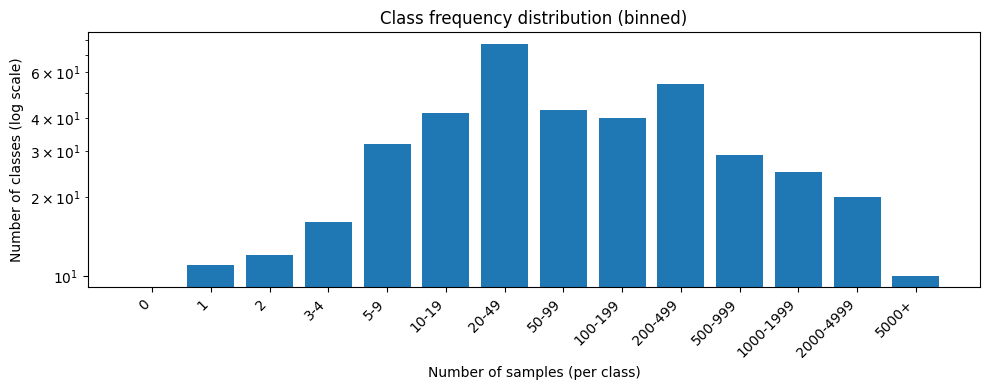

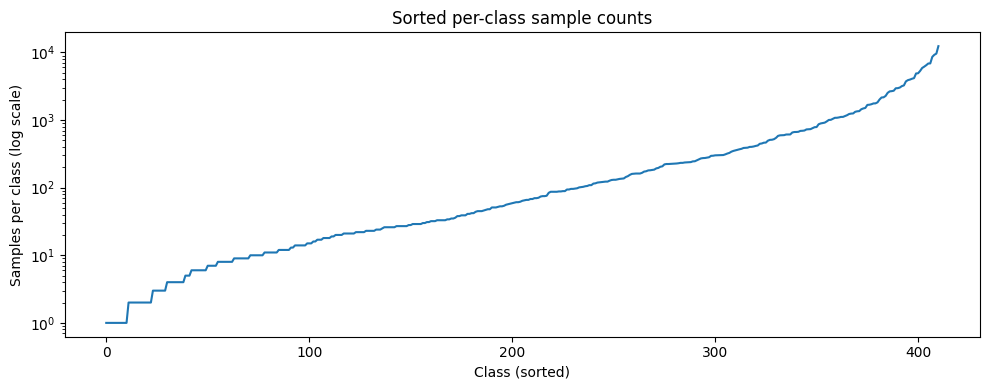

In [25]:
from uncertainbird.utils.plotting import plot_class_frequency

plot_class_frequency(targets_targetclasses)

In [37]:
from uncertainbird.utils.plotting import print_metrics

metrics_targetclasses = print_metrics(predictions_targetclasses, targets_targetclasses)

Accuracy: tensor(0.2271)
cmAP: tensor(0.3156)
Precision: tensor(0.0050)
Recall: tensor(0.9890)
F1 Score: tensor(0.0061)
AUROC: tensor(0.9704)
ECE: tensor(0.7172)
ECE Weighted: tensor(0.8106)
ECE Top-3: tensor(0.7994)
ECE Top-5: tensor(0.8585)
ECE Top-10: tensor(0.8546)
ECE Top-21: tensor(0.8799)
Miscalibration Score (MCS): tensor(0.8106)
ECE Under-confidence: tensor(-1.7059e-07)
ECE Over-confidence: tensor(0.8106)


<Axes: title={'center': 'Reliability Diagram - ConvNeXt_BS on BirdSet`s target classes | ECE weighted = 81.06%'}, xlabel='Mean Predicted Probability', ylabel='Fraction of Positives'>

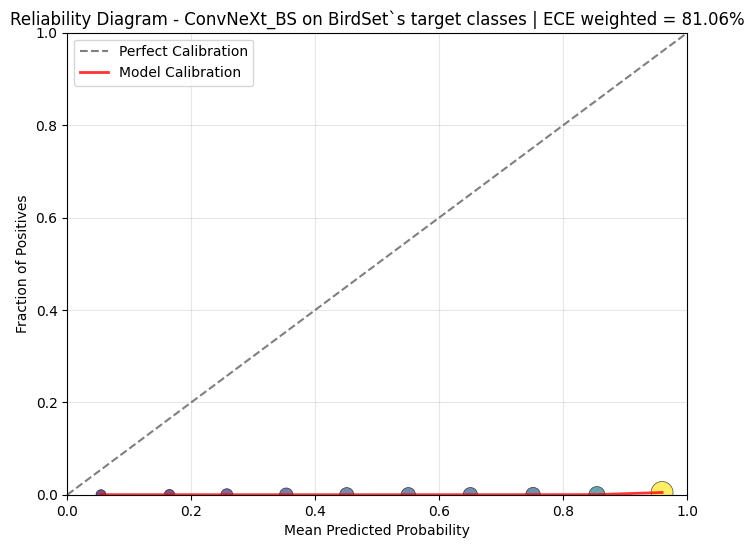

In [38]:
# reliability diagram
from uncertainbird.utils.plotting import plot_reliability_diagram

plot_reliability_diagram(
    predictions_targetclasses,
    targets_targetclasses,
    n_bins=10,
    title=f"Reliability Diagram - ConvNeXt_BS on BirdSet`s target classes | ECE weighted = {metrics_targetclasses['ece_weighted']*100:.2f}%",
)

## Class-wise Calibration Plots

In [39]:
# only select classes with target labels
for key in list(data.keys()):
    # keep the dict structure; only replace the predictions/targets tensors
    preds = data[key]["predictions"][:, targets.sum(dim=0).gt(0)]
    tars = data[key]["targets"][:, targets.sum(dim=0).gt(0)]
    data[key]["predictions"] = preds
    data[key]["targets"] = tars
    # metadata and color remain unchanged

KeyboardInterrupt: 

In [40]:
# compute metrics
for key in data:
    print("Computing metrics for", key)
    preds = data[key]["predictions"]
    tar = data[key]["targets"]
    data[key]["metrics"] = print_metrics(preds, tar)

Computing metrics for HSN
Accuracy: tensor(0.2788)
cmAP: tensor(0.5270)
Precision: tensor(0.0015)
Recall: tensor(0.0510)
F1 Score: tensor(0.0027)
AUROC: tensor(0.0459)
ECE: tensor(0.6832)
ECE Weighted: tensor(0.6882)
ECE Top-3: tensor(0.6684)
ECE Top-5: tensor(0.6540)
ECE Top-10: tensor(0.7832)
ECE Top-21: tensor(0.8096)
Miscalibration Score (MCS): tensor(0.6882)
ECE Under-confidence: tensor(0.)
ECE Over-confidence: tensor(0.6882)
Computing metrics for NBP
Accuracy: tensor(0.2322)
cmAP: tensor(0.6584)
Precision: tensor(0.0042)
Recall: tensor(0.1241)
F1 Score: tensor(0.0080)
AUROC: tensor(0.1156)
ECE: tensor(0.7129)
ECE Weighted: tensor(0.9156)
ECE Top-3: tensor(0.8796)
ECE Top-5: tensor(0.8997)
ECE Top-10: tensor(0.8991)
ECE Top-21: tensor(0.8985)
Miscalibration Score (MCS): tensor(0.9156)
ECE Under-confidence: tensor(0.)
ECE Over-confidence: tensor(0.9156)
Computing metrics for NES
Accuracy: tensor(0.1718)
cmAP: tensor(0.4001)
Precision: tensor(0.0018)
Recall: tensor(0.2143)
F1 Score:

### Reliability Diagram
```

#### Combined

<Axes: title={'center': 'Combined Reliability Diagram - ConvNeXt_BS on BirdSet'}, xlabel='Mean Predicted Probability', ylabel='Fraction of Positives'>

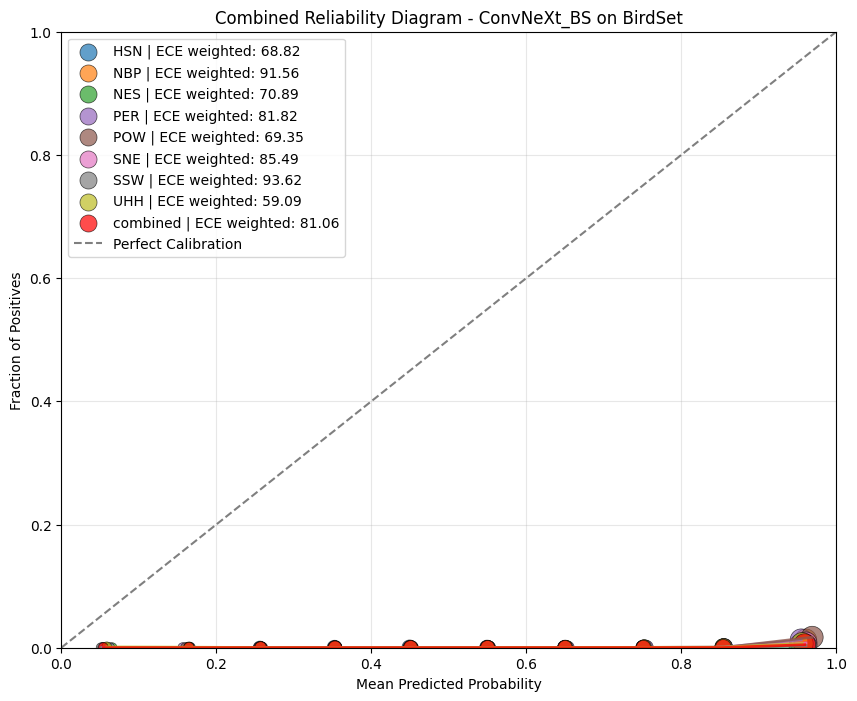

In [41]:
from uncertainbird.utils.plotting import plot_combined_reliability_diagram

# add average / combined data of all datasets
data["combined"] = {
    "predictions": predictions_targetclasses,
    "targets": targets_targetclasses,
    "metadata": None,
    "metrics": metrics_targetclasses,
    "color": "red",  # color for combined plot
}

plot_combined_reliability_diagram(
    data, n_bins=10, title="Combined Reliability Diagram - ConvNeXt_BS on BirdSet"
)

#### Per class

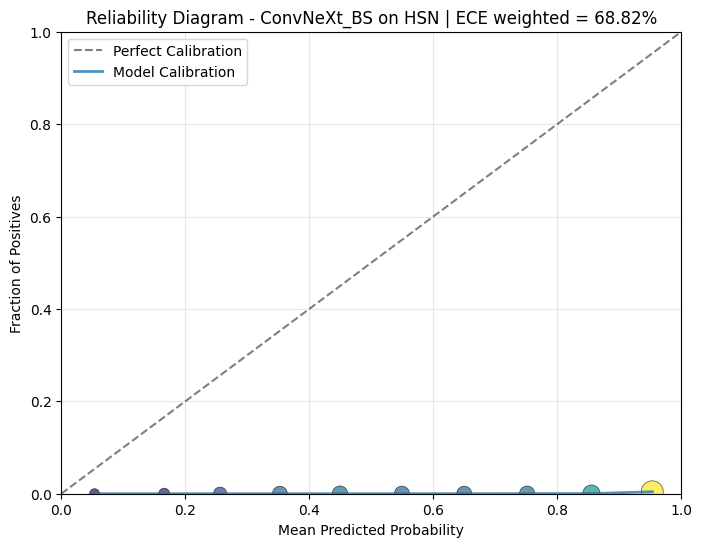

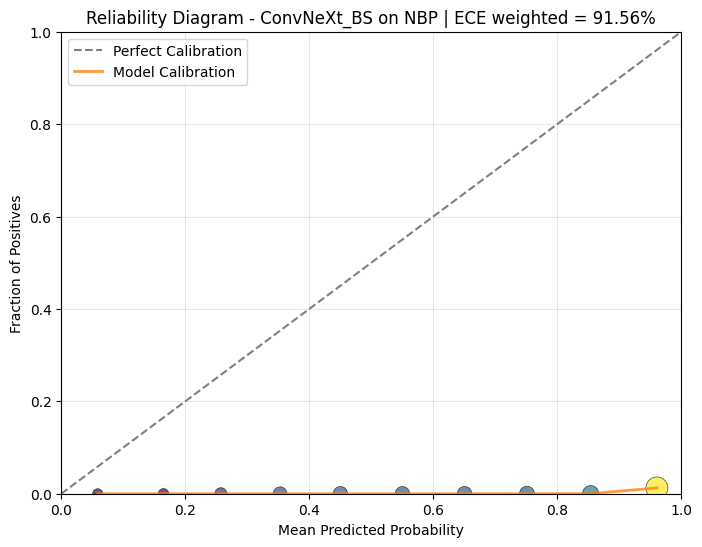

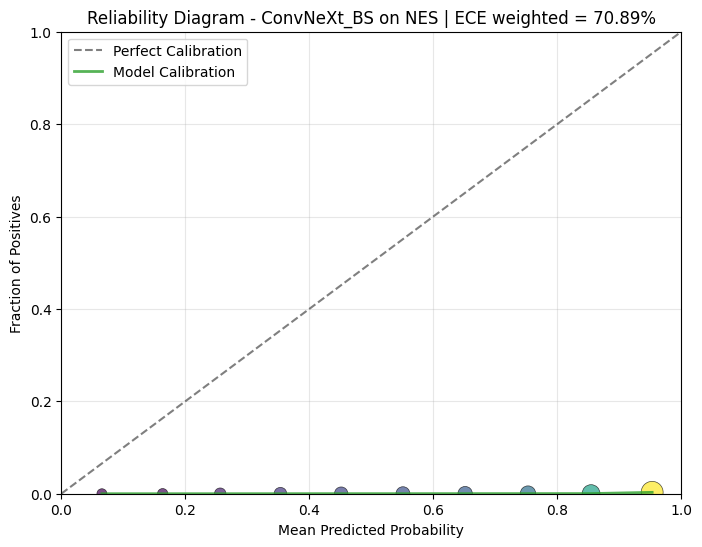

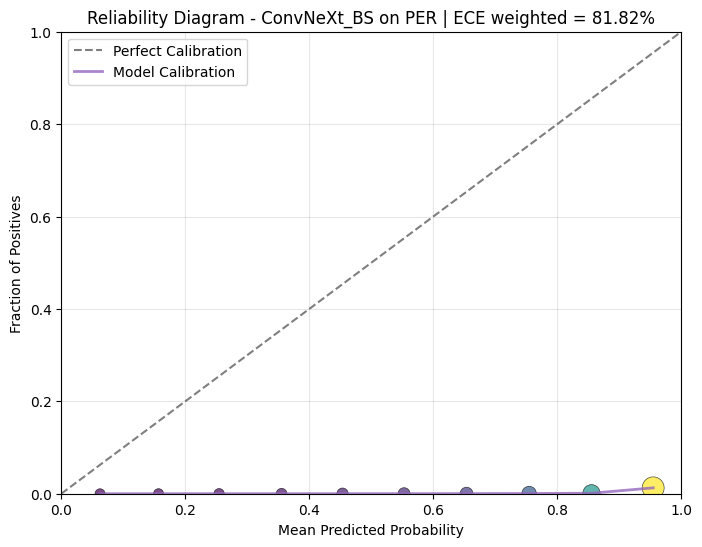

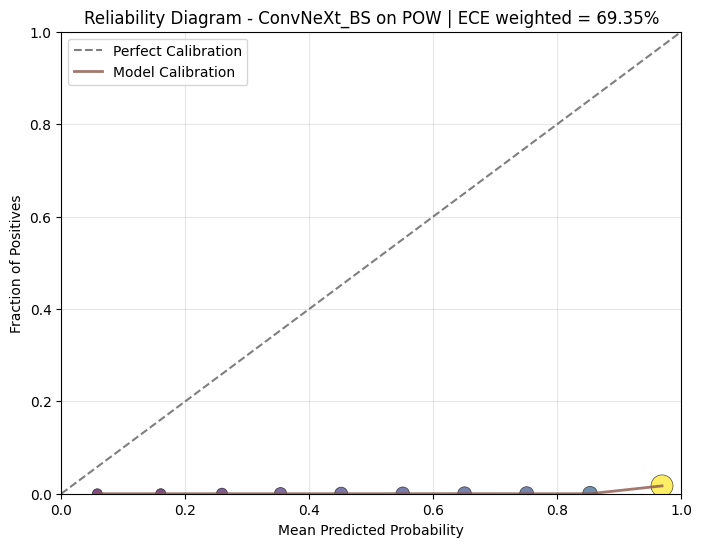

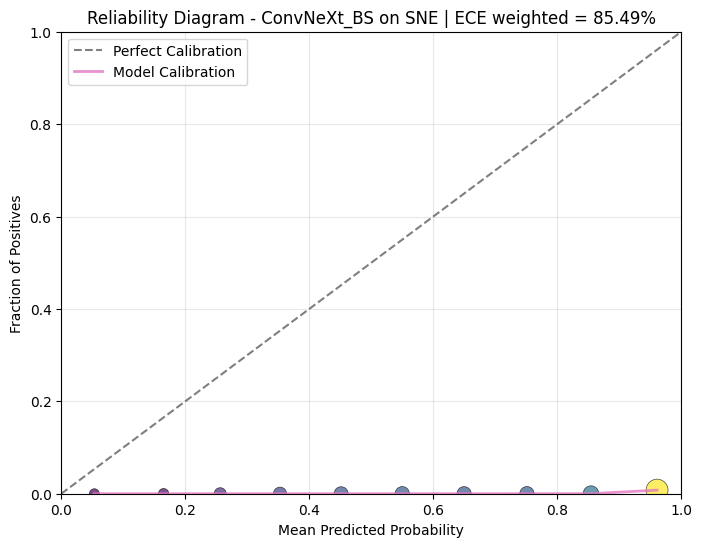

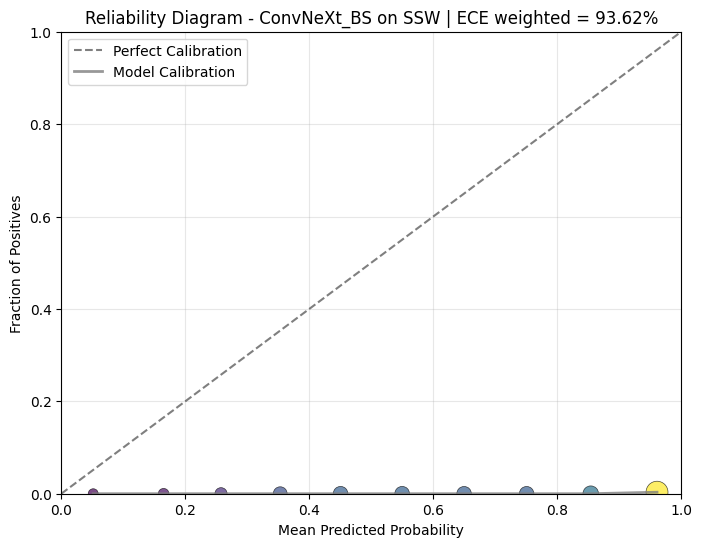

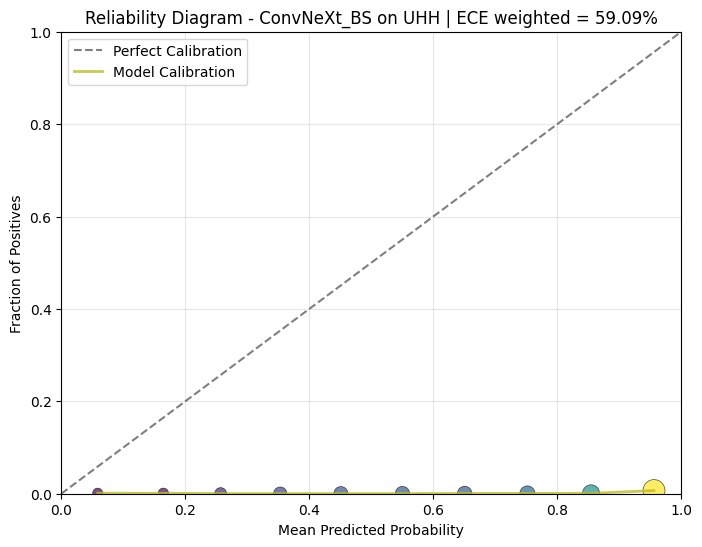

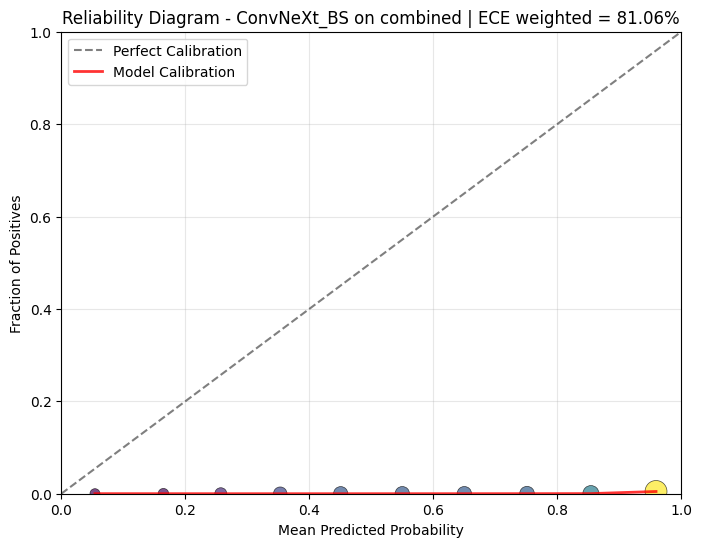

In [42]:
for key in data:
    plot_reliability_diagram(
        data[key]["predictions"],
        data[key]["targets"],
        n_bins=10,
        title=f"Reliability Diagram - ConvNeXt_BS on {key} | ECE weighted = {data[key]['metrics']['ece_weighted']*100:.2f}%",
        color=data[key].get("color", "red"),
    )

In [43]:
from uncertainbird.utils.misc import class_wise_statistics

preds = predictions_targetclasses.float()
tar = targets_targetclasses.int()

class_stats = class_wise_statistics(preds, tar, n_bins=10)

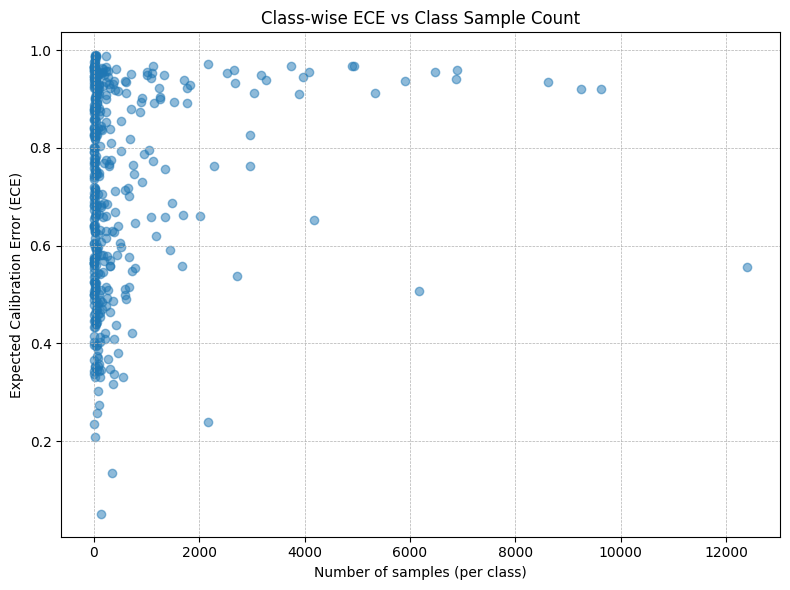

In [44]:
# plot ece vs class sample count
plt.figure(figsize=(8, 6))
plt.scatter(class_stats["positive_samples"], class_stats["ece"], alpha=0.5)
plt.xlabel("Number of samples (per class)")
plt.ylabel("Expected Calibration Error (ECE)")
plt.title("Class-wise ECE vs Class Sample Count")
plt.grid(True, ls="--", lw=0.5)
plt.tight_layout()
plt.show()

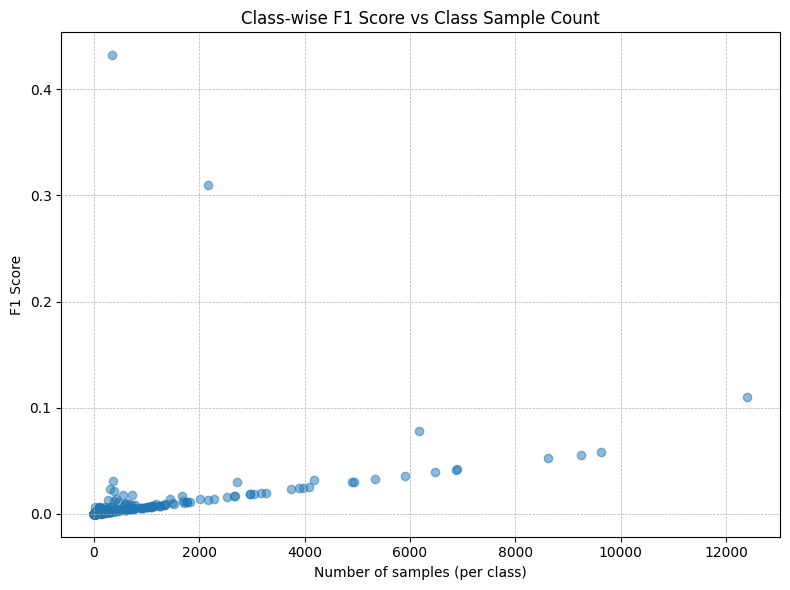

In [45]:
# f1 vs class sample count
plt.figure(figsize=(8, 6))
plt.scatter(class_stats["positive_samples"], class_stats["f1_score"], alpha=0.5)
plt.xlabel("Number of samples (per class)")
plt.ylabel("F1 Score")
plt.title("Class-wise F1 Score vs Class Sample Count")
plt.grid(True, ls="--", lw=0.5)
plt.tight_layout()

In [46]:
# print cmAP for each dataset in the format "Dataset: <name>, cmAP: <value>"
print("cmAP per dataset:")
for key in data:
    print(f"Dataset: {key}, cmAP: {data[key]['metrics']['cmAP']*100:.2f}")

print("ECE for each dataset:")
for key in data:
    print(f"Dataset: {key}, ece: {data[key]['metrics']['ece_weighted']*100:.2f}")
print("MCS for each dataset:")
for key in data:
    print(f"Dataset: {key}, mcs: {data[key]['metrics']['mcs']*100:.2f}")
print("Under confidence score for each dataset:")
for key in data:
    print(f"Dataset: {key}, mcs: {data[key]['metrics']['ece_under']*100:.2f}")
print("Over confidence score for each dataset:")
for key in data:
    print(f"Dataset: {key}, mcs: {data[key]['metrics']['ece_over']*100:.2f}")

cmAP per dataset:
Dataset: HSN, cmAP: 52.70
Dataset: NBP, cmAP: 65.84
Dataset: NES, cmAP: 40.01
Dataset: PER, cmAP: 22.94
Dataset: POW, cmAP: 54.09
Dataset: SNE, cmAP: 34.97
Dataset: SSW, cmAP: 47.27
Dataset: UHH, cmAP: 38.25
Dataset: combined, cmAP: 31.56
ECE for each dataset:
Dataset: HSN, ece: 68.82
Dataset: NBP, ece: 91.56
Dataset: NES, ece: 70.89
Dataset: PER, ece: 81.82
Dataset: POW, ece: 69.35
Dataset: SNE, ece: 85.49
Dataset: SSW, ece: 93.62
Dataset: UHH, ece: 59.09
Dataset: combined, ece: 81.06
MCS for each dataset:
Dataset: HSN, mcs: 68.82
Dataset: NBP, mcs: 91.56
Dataset: NES, mcs: 70.89
Dataset: PER, mcs: 81.82
Dataset: POW, mcs: 69.35
Dataset: SNE, mcs: 85.49
Dataset: SSW, mcs: 93.62
Dataset: UHH, mcs: 59.09
Dataset: combined, mcs: 81.06
Under confidence score for each dataset:
Dataset: HSN, mcs: 0.00
Dataset: NBP, mcs: 0.00
Dataset: NES, mcs: 0.00
Dataset: PER, mcs: 0.00
Dataset: POW, mcs: 0.00
Dataset: SNE, mcs: 0.00
Dataset: SSW, mcs: 0.00
Dataset: UHH, mcs: -0.00
Datas